In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from matplotlib import pyplot
from xgboost import plot_importance

color = sns.color_palette()

In [ ]:
#skip this block is already installed

!pip install xgboost
!pip install lightgbm
!pip install pandas
!pip install matplotlib
!pip install seaborn



In [6]:
#PATH_TO_FILE = "../../psykose/schizophrenia-features.csv"

#my baseline features
PATH_TO_FILE = "../baseline_time_period.csv"

_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 2018, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 10,
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": 2018,
    "class_weight": "balanced"
}

_PARAMS_XGB = {
    "nthread":16, "learning_rate": 0.3, "gamma": 0, "max_depth": 6, "verbosity": 0,
    "min_child_weight": 1, "max_delta_step": 0, "subsample": 1.0, "colsample_bytree": 1.0,
    "objective":"binary:logistic", "num_class":1, "eval_metric":"logloss", "seed":2018,
}

_PARAMS_LIGHTGB = {
    "task": "train", "num_class":1, "boosting": "gbdt", "verbosity": -1,
    "objective": "binary", "metric": "binary_logloss", "metric_freq":50, "is_training_metric":False,
    "max_depth":4, "num_leaves": 31, "learning_rate": 0.01, "feature_fraction": 1.0, "bagging_fraction": 1.0,
    "bagging_freq": 0, "bagging_seed": 2018, "num_threads":16
}

# Data Frame to collect all results of the classifiers
df_result = pd.DataFrame()
df_feature_importance = pd.DataFrame()

In [7]:
data = pd.read_csv(PATH_TO_FILE)

dataX = data.copy().drop(["class", "class_str", "userid"], axis=1)
dataY = data["class"].copy()

scaler = pp.StandardScaler(copy=True)

dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])


testset_size = 0.5

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=testset_size,
    random_state=2019,
    stratify=dataY
)

In [8]:
def plot_prc_curve(y_preds, y_trues, title=None):
    
    precision, recall, _ = metrics.precision_recall_curve(
        y_trues,
        y_preds
    )

    average_precision = metrics.average_precision_score(
        y_trues,
        y_preds
    )

    print("Average Precision = %.2f" % average_precision)
    
    plt.step(recall, precision, color="k", alpha=0.7, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.3, color="k")

    if title is None:
        title = "PRC: Average Precision = %.2f" % average_precision

    plt.title(title)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.show()
    
    return average_precision

def plot_roc_curve(y_preds, y_trues, title=None):
    
    fpr, tpr, _ = metrics.roc_curve(y_trues, y_preds)

    auc_roc = metrics.auc(fpr, tpr)

    print("AUCROC = %.2f" % auc_roc)

    if title is None:
        title = "AUCROC = %.2f" % auc_roc

    plt.title(title)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
    plt.plot(fpr, tpr, color="r", lw=2, label="ROC curve")
    plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")

    plt.show()
    
    return auc_roc


def model_predict_k_fold( train_func, pred_func, model=None, n_splits=10, shuffle=True, random_state=2018 ):
     
    y_preds = []
    y_trues = []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func( model, x_fold_train, y_fold_train, x_fold_test, y_fold_test )
        y_pred = pred_func( model, x_fold_test )

        y_preds.extend( list(y_pred) )
        y_trues.extend( list(y_fold_test) )

    return model, np.array(y_preds), np.array(y_trues)


# Logistic Regression

Average Precision = 0.91


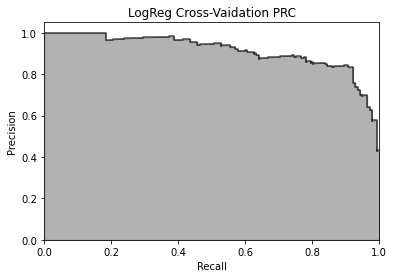

AUCROC = 0.94


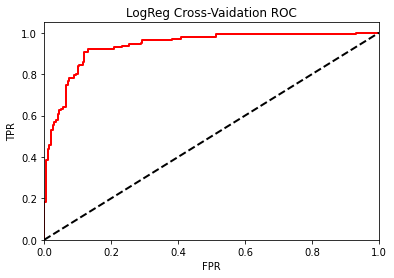

Average Precision = 0.91


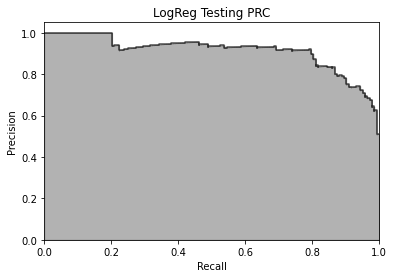

AUCROC = 0.94


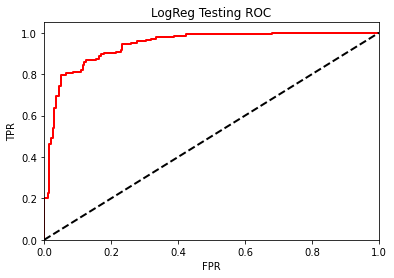

Feature: 0, Score: 0.73606
Feature: 1, Score: -1.77990
Feature: 2, Score: -0.14228
Feature: 3, Score: 0.11271
Feature: 4, Score: 0.02073
Feature: 5, Score: 0.64894
Feature: 6, Score: -1.61407
Feature: 7, Score: 0.41123
Feature: 8, Score: 0.98472
Feature: 9, Score: -0.14970
Feature: 10, Score: 0.81521
Feature: 11, Score: -1.39819
Feature: 12, Score: 1.48551
Feature: 13, Score: -0.22539
Feature: 14, Score: -0.02979


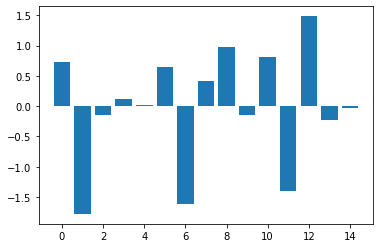

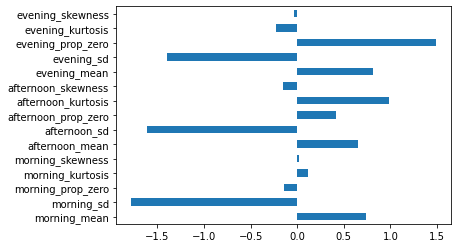

In [9]:
def logreg_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def logreg_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

logreg = LogisticRegression( **_PARAMS_LORGREG )

logreg, logreg_y_preds, logreg_y_trues = model_predict_k_fold( logreg_train_func, logreg_pred_func, logreg )
logreg_test_preds = logreg_pred_func( logreg, X_TEST )

#precision-recall curves (PRC)
#Receiver-operator curves (ROC)
average_precision = plot_prc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( logreg_y_preds, logreg_y_trues, "LogReg Cross-Vaidation ROC" )

plot_prc_curve( logreg_test_preds, Y_TEST, "LogReg Testing PRC" )
plot_roc_curve( logreg_test_preds, Y_TEST, "LogReg Testing ROC" )


#collect the result
row_stats = {'classifier': "Logistic Regression", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )

# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

(pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
  # .nlargest(4)
   .plot(kind='barh'))


series_features = pd.Series(logreg.coef_[0], index=X_TRAIN.columns)
row_features = {'classifier': "Logistic Regression"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Random Forest

Average Precision = 0.86


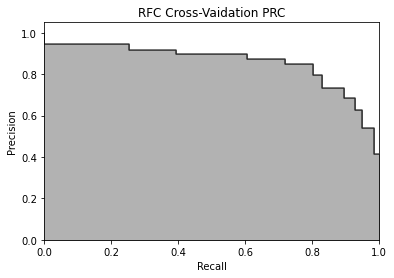

AUCROC = 0.91


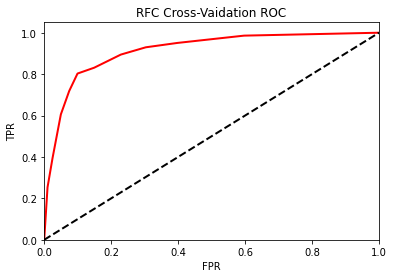

Average Precision = 0.89


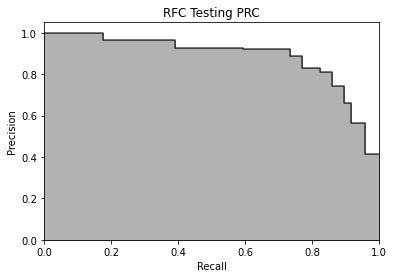

AUCROC = 0.91


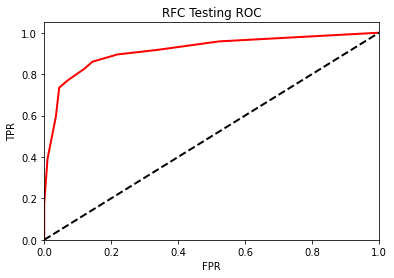

Feature: 0, Score: 0.03611
Feature: 1, Score: 0.05230
Feature: 2, Score: 0.05307
Feature: 3, Score: 0.03121
Feature: 4, Score: 0.02678
Feature: 5, Score: 0.09759
Feature: 6, Score: 0.13965
Feature: 7, Score: 0.05908
Feature: 8, Score: 0.04839
Feature: 9, Score: 0.03752
Feature: 10, Score: 0.08967
Feature: 11, Score: 0.13571
Feature: 12, Score: 0.12836
Feature: 13, Score: 0.04370
Feature: 14, Score: 0.02086


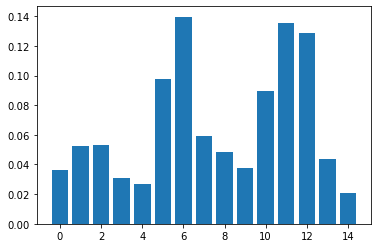

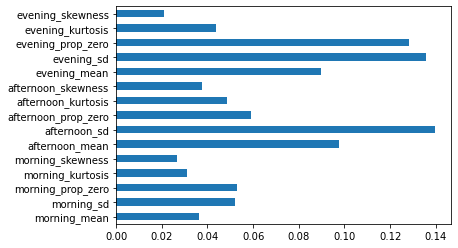

In [10]:
def rfc_train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model

def rfc_pred_func(model, data):
    return model.predict_proba(data)[:, 1]

rfc = RandomForestClassifier( **_PARAMS_RFC )

rfc, rfc_y_preds, rfc_y_trues = model_predict_k_fold( rfc_train_func, rfc_pred_func, rfc )
rfc_test_preds = rfc_pred_func( rfc, X_TEST )

average_precision = plot_prc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( rfc_y_preds, rfc_y_trues, "RFC Cross-Vaidation ROC" )

plot_prc_curve( rfc_test_preds, Y_TEST, "RFC Testing PRC" )
plot_roc_curve( rfc_test_preds, Y_TEST, "RFC Testing ROC" )



#collect the result
row_stats = {'classifier': "Random Forest", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#
(pd.Series(importance, index=X_TRAIN.columns)
   #.nlargest(4)
   .plot(kind='barh'))



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "Random Forest"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


# XGBoost

[0]	train-logloss:0.50888+0.00747	test-logloss:0.55923+0.02623
[50]	train-logloss:0.02142+0.00112	test-logloss:0.41607+0.11514
[100]	train-logloss:0.01543+0.00053	test-logloss:0.45001+0.12159
[150]	train-logloss:0.01358+0.00041	test-logloss:0.45806+0.12334
[200]	train-logloss:0.01281+0.00035	test-logloss:0.46435+0.12332
[211]	train-logloss:0.01267+0.00032	test-logloss:0.46552+0.12286
[0]	train-logloss:0.50216+0.00354	test-logloss:0.56580+0.02156
[50]	train-logloss:0.02134+0.00103	test-logloss:0.31352+0.07747
[100]	train-logloss:0.01516+0.00057	test-logloss:0.33203+0.09672
[150]	train-logloss:0.01344+0.00046	test-logloss:0.34092+0.10435
[200]	train-logloss:0.01272+0.00038	test-logloss:0.34716+0.10795
[217]	train-logloss:0.01254+0.00037	test-logloss:0.34925+0.10942
[0]	train-logloss:0.50846+0.00264	test-logloss:0.57884+0.00470
[50]	train-logloss:0.02247+0.00064	test-logloss:0.36165+0.09508
[100]	train-logloss:0.01582+0.00046	test-logloss:0.38734+0.10415
[150]	train-logloss:0.01371+0.0002

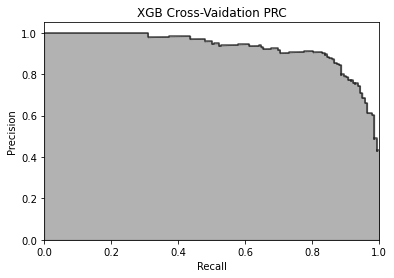

AUCROC = 0.94


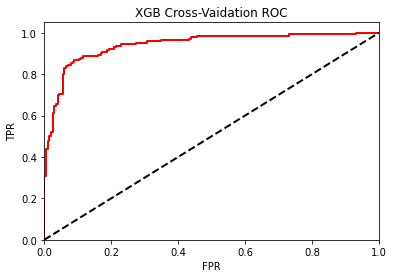

Average Precision = 0.92


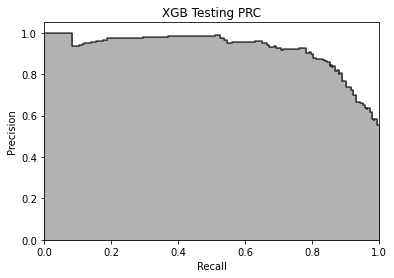

AUCROC = 0.94


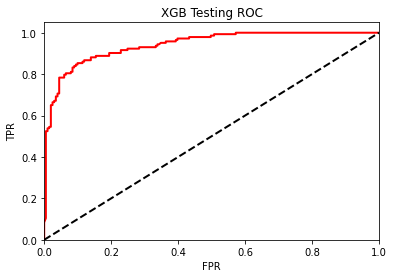

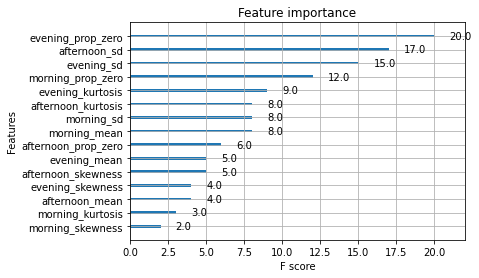

In [11]:
def xgb_train_func(model, x_train, y_train, x_test, y_test):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)

    bst = xgb.cv(_PARAMS_XGB,
        dtrain,
        num_boost_round=2000,
        nfold=5,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    best_rounds = np.argmin(bst["test-logloss-mean"])
    bst = xgb.train(_PARAMS_XGB, dtrain, best_rounds)
    return bst

def xgb_pred_func(model, data):
    data = xgb.DMatrix(data=data)
    pred = model.predict(data)
    return pred

xgb_model, xgb_y_preds, xgb_y_trues = model_predict_k_fold( xgb_train_func, xgb_pred_func )
xgb_test_preds = xgb_pred_func( xgb_model, X_TEST )

average_precision = plot_prc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( xgb_y_preds, xgb_y_trues, "XGB Cross-Vaidation ROC" )

plot_prc_curve( xgb_test_preds, Y_TEST, "XGB Testing PRC" )
plot_roc_curve( xgb_test_preds, Y_TEST, "XGB Testing ROC" )



#collect the result
row_stats = {'classifier': "XGBoot", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


# plot feature importance
plot_importance(xgb_model)
pyplot.show()



series_features = pd.Series(importance, index=X_TRAIN.columns)
row_features = {'classifier': "XGBoost"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# LightGBM

/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Average Precision = 0.95


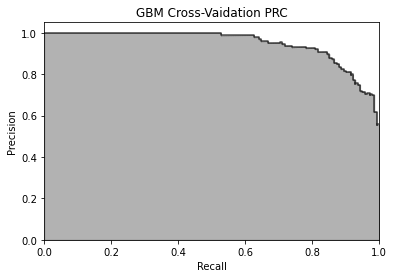

AUCROC = 0.96


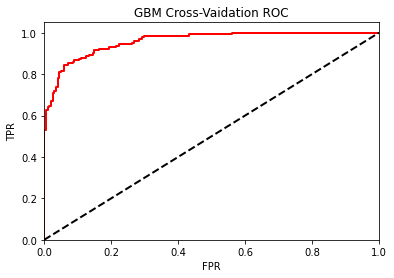

Average Precision = 0.95


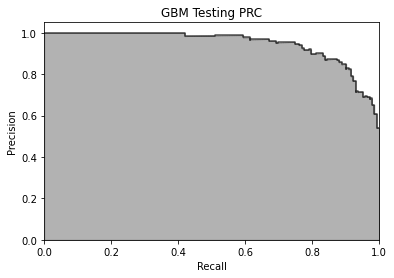

AUCROC = 0.96


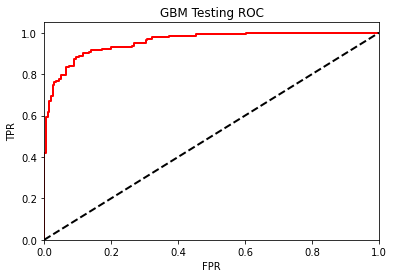

Plotting feature importances...


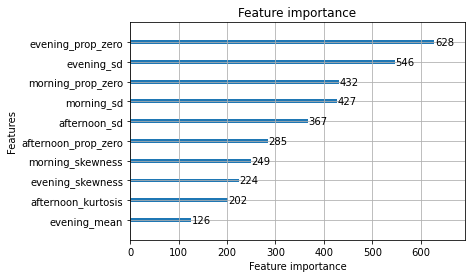

In [12]:
def gbm_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return gbm

def gbm_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

gbm, gbm_y_preds, gbm_y_trues = model_predict_k_fold( gbm_train_func, gbm_pred_func )
gbm_test_preds = gbm_pred_func( gbm, X_TEST )

average_precision = plot_prc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( gbm_y_preds, gbm_y_trues, "GBM Cross-Vaidation ROC" )

plot_prc_curve( gbm_test_preds, Y_TEST, "GBM Testing PRC" )
plot_roc_curve( gbm_test_preds, Y_TEST, "GBM Testing ROC" )




#collect the result
row_stats = {'classifier': "LightGBM", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )


print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()



df_feature_importance_2 = (
    pd.DataFrame({
        'feature': gbm.feature_name(),
        'importance': gbm.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

series_features = pd.Series(gbm.feature_importance(), index=gbm.feature_name())
row_features = {'classifier': "LightGBM"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)



# Ensemble

/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/fellipeferreira/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Average Precision = 0.95


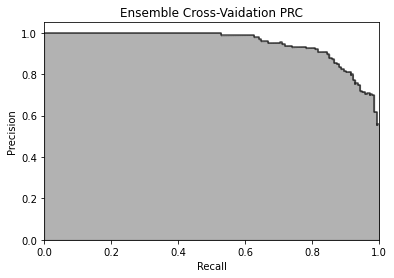

AUCROC = 0.96


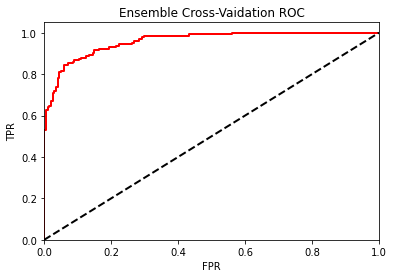

Average Precision = 0.95


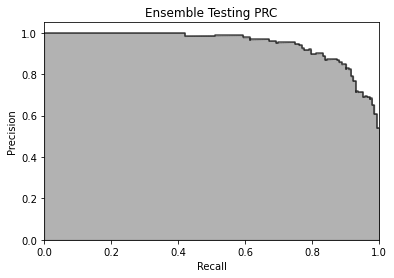

AUCROC = 0.96


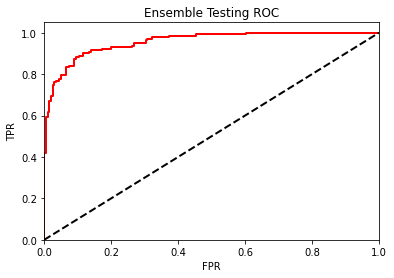

Plotting feature importances...


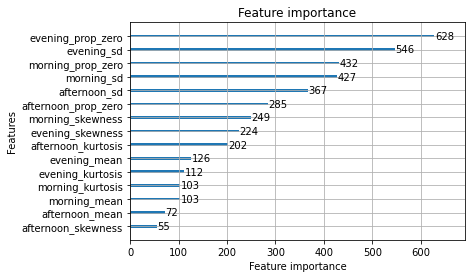

In [13]:
def ensemble_train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    ensemble = lgb.train(
        _PARAMS_LIGHTGB,
        lgb_train,
        verbose_eval=False,
        num_boost_round=2000,
        valid_sets=lgb_eval,
        early_stopping_rounds=200
    )

    return ensemble

def ensemble_pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)

ensemble, ensemble_y_preds, ensemble_y_trues = model_predict_k_fold( ensemble_train_func, ensemble_pred_func )
ensemble_test_preds = ensemble_pred_func( ensemble, X_TEST )

average_precision = plot_prc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation PRC" )
auc_roc           = plot_roc_curve( ensemble_y_preds, ensemble_y_trues, "Ensemble Cross-Vaidation ROC" )

plot_prc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing PRC" )
plot_roc_curve( ensemble_test_preds, Y_TEST, "Ensemble Testing ROC" )


#collect the result
row_stats = {'classifier': "Ensemble", 
             'Average Precision': average_precision,
             'AUCROC': auc_roc,
             'testset_size': testset_size}
df_result = df_result.append(row_stats, ignore_index=True )



print('Plotting feature importances...')
ax = lgb.plot_importance(ensemble)
plt.show()




series_features = pd.Series(ensemble.feature_importance(), index=ensemble.feature_name())
row_features = {'classifier': "Ensemble"}
for index, value in series_features.items():
    new_values =  {index: value}
    row_features.update(new_values)
df_feature_importance = df_feature_importance.append(row_features, ignore_index=True)


In [14]:
df_result = df_result[['classifier', 'Average Precision', 'AUCROC', 'testset_size']]
df_result


,classifier,Average Precision,AUCROC,testset_size
0,Logistic Regression,0.914541,0.937355,0.5
1,Random Forest,0.859989,0.913005,0.5
2,XGBoot,0.928329,0.942085,0.5
3,LightGBM,0.949978,0.959183,0.5
4,Ensemble,0.949978,0.959183,0.5


In [15]:
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero', 'kurtosis', 'skew']]
#df_feature_importance = df_feature_importance[['classifier', 'mean', 'sd', 'prop_zero']]
df_feature_importance

,afternoon_kurtosis,afternoon_mean,afternoon_prop_zero,afternoon_sd,afternoon_skewness,classifier,evening_kurtosis,evening_mean,evening_prop_zero,evening_sd,evening_skewness,morning_kurtosis,morning_mean,morning_prop_zero,morning_sd,morning_skewness
0,0.984722,0.648944,0.411228,-1.614072,-0.149704,Logistic Regression,-0.225387,0.815214,1.485514,-1.398185,-0.029793,0.112705,0.736065,-0.142280,-1.779904,0.020729
1,0.048393,0.097586,0.059082,0.139650,0.037515,Random Forest,0.043697,0.089672,0.128365,0.135714,0.020860,0.031206,0.036105,0.053069,0.052303,0.026784
2,0.048393,0.097586,0.059082,0.139650,0.037515,XGBoost,0.043697,0.089672,0.128365,0.135714,0.020860,0.031206,0.036105,0.053069,0.052303,0.026784
3,202.000000,72.000000,285.000000,367.000000,55.000000,LightGBM,112.000000,126.000000,628.000000,546.000000,224.000000,103.000000,103.000000,432.000000,427.000000,249.000000
4,202.000000,72.000000,285.000000,367.000000,55.000000,Ensemble,112.000000,126.000000,628.000000,546.000000,224.000000,103.000000,103.000000,432.000000,427.000000,249.000000
